## Módulos

In [147]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Ridge, LassoLarsCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import mean_absolute_error
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

### Carregar dataset de treino

In [148]:
# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
#njobs = 4

In [149]:
train = pd.read_csv('train.csv')
print(f'Train: {train.shape}')

Train: (1460, 81)


## Verificar id's repetidos, outliers, separar e usar log transform no y

In [150]:
# Valores repetidos
unique_ids = len(set(train.Id))
total_ids = train.shape[0]
dupli_ids = total_ids - unique_ids
print(f'Existem {dupli_ids} ids repetidas para um total de {total_ids} IDs')
train.drop("Id", axis = 1, inplace = True)

Existem 0 ids repetidas para um total de 1460 IDs


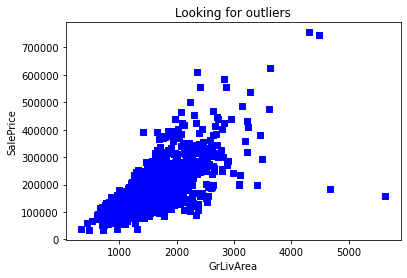

In [151]:
# Verificando e retirando os outliers como recomendado por Dean De Cock para o nosso dataset
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()
train = train[train.GrLivArea < 4000]

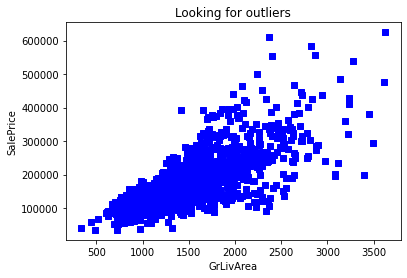

In [152]:
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

In [153]:
# usar log transform nos preços para se adequar à pontuação oficial
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

### Corrigir missing values e codificar features

In [154]:
# Resolver os missing values das features onde média, mediana e moda não são adequados.
# Alley: aqui NA significa que não há acesso a alley
train.loc[:, 'Alley'] = train.loc[:,'Alley'].fillna('None')

# BedroomAbvGr : NA most likely means 0
train.loc[:, "BedroomAbvGr"] = train.loc[:, "BedroomAbvGr"].fillna(0
                                                                  )
# BsmtQual etc : data description says NA for basement features is "no basement"
train.loc[:, "BsmtQual"] = train.loc[:, "BsmtQual"].fillna("No")
train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")
train.loc[:, "BsmtFullBath"] = train.loc[:, "BsmtFullBath"].fillna(0)
train.loc[:, "BsmtHalfBath"] = train.loc[:, "BsmtHalfBath"].fillna(0)
train.loc[:, "BsmtUnfSF"] = train.loc[:, "BsmtUnfSF"].fillna(0)

# CentralAir : NA most likely means No
train.loc[:, "CentralAir"] = train.loc[:, "CentralAir"].fillna("N")

# Condition : NA most likely means Normal
train.loc[:, "Condition1"] = train.loc[:, "Condition1"].fillna("Norm")
train.loc[:, "Condition2"] = train.loc[:, "Condition2"].fillna("Norm")

# EnclosedPorch : NA most likely means no enclosed porch
train.loc[:, "EnclosedPorch"] = train.loc[:, "EnclosedPorch"].fillna(0)

# External stuff : NA most likely means average
train.loc[:, "ExterCond"] = train.loc[:, "ExterCond"].fillna("TA")
train.loc[:, "ExterQual"] = train.loc[:, "ExterQual"].fillna("TA")

# Fence : data description says NA means "no fence"
train.loc[:, "Fence"] = train.loc[:, "Fence"].fillna("No")

# FireplaceQu : data description says NA means "no fireplace"
train.loc[:, "FireplaceQu"] = train.loc[:, "FireplaceQu"].fillna("No")
train.loc[:, "Fireplaces"] = train.loc[:, "Fireplaces"].fillna(0)

# Functional : data description says NA means typical
train.loc[:, "Functional"] = train.loc[:, "Functional"].fillna("Typ")

# GarageType etc : data description says NA for garage features is "no garage"
train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")
train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)
train.loc[:, "GarageCars"] = train.loc[:, "GarageCars"].fillna(0)

# HalfBath : NA most likely means no half baths above grade
train.loc[:, "HalfBath"] = train.loc[:, "HalfBath"].fillna(0)

# HeatingQC : NA most likely means typical
train.loc[:, "HeatingQC"] = train.loc[:, "HeatingQC"].fillna("TA")

# KitchenAbvGr : NA most likely means 0
train.loc[:, "KitchenAbvGr"] = train.loc[:, "KitchenAbvGr"].fillna(0)

# KitchenQual : NA most likely means typical
train.loc[:, "KitchenQual"] = train.loc[:, "KitchenQual"].fillna("TA")

# LotFrontage : NA most likely means no lot frontage
train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)

# LotShape : NA most likely means regular
train.loc[:, "LotShape"] = train.loc[:, "LotShape"].fillna("Reg")

# MasVnrType : NA most likely means no veneer
train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")
train.loc[:, "MasVnrArea"] = train.loc[:, "MasVnrArea"].fillna(0)

# MiscFeature : data description says NA means "no misc feature"
train.loc[:, "MiscFeature"] = train.loc[:, "MiscFeature"].fillna("No")
train.loc[:, "MiscVal"] = train.loc[:, "MiscVal"].fillna(0)

# OpenPorchSF : NA most likely means no open porch
train.loc[:, "OpenPorchSF"] = train.loc[:, "OpenPorchSF"].fillna(0)

# PavedDrive : NA most likely means not paved
train.loc[:, "PavedDrive"] = train.loc[:, "PavedDrive"].fillna("N")

# PoolQC : data description says NA means "no pool"
train.loc[:, "PoolQC"] = train.loc[:, "PoolQC"].fillna("No")
train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)

# SaleCondition : NA most likely means normal sale
train.loc[:, "SaleCondition"] = train.loc[:, "SaleCondition"].fillna("Normal")

# ScreenPorch : NA most likely means no screen porch
train.loc[:, "ScreenPorch"] = train.loc[:, "ScreenPorch"].fillna(0)

# TotRmsAbvGrd : NA most likely means 0
train.loc[:, "TotRmsAbvGrd"] = train.loc[:, "TotRmsAbvGrd"].fillna(0)

# Utilities : NA most likely means all public utilities
train.loc[:, "Utilities"] = train.loc[:, "Utilities"].fillna("AllPub")

# WoodDeckSF : NA most likely means no wood deck
train.loc[:, "WoodDeckSF"] = train.loc[:, "WoodDeckSF"].fillna(0)

In [155]:
# Some numerical features are actually really categories
train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [156]:
# Encode some categorical features as ordered numbers when there is information in the order
train = train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

### Verificar correlação entre features e objetivo

In [157]:
# Encontrar as features mais importantes em relação ao objetivo:
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice        1.000
OverallQual      0.819
GrLivArea        0.719
ExterQual        0.681
GarageCars       0.680
KitchenQual      0.667
GarageArea       0.655
TotalBsmtSF      0.642
BsmtQual         0.615
1stFlrSF         0.614
FullBath         0.591
YearBuilt        0.589
YearRemodAdd     0.569
FireplaceQu      0.547
GarageYrBlt      0.544
TotRmsAbvGrd     0.533
Fireplaces       0.487
HeatingQC        0.474
MasVnrArea       0.426
BsmtFinSF1       0.383
GarageQual       0.365
GarageCond       0.359
BsmtExposure     0.333
BsmtFinType1     0.333
WoodDeckSF       0.331
OpenPorchSF      0.327
HalfBath         0.311
2ndFlrSF         0.307
PavedDrive       0.306
BsmtCond         0.277
LotArea          0.259
BsmtFullBath     0.239
BsmtUnfSF        0.223
BedroomAbvGr     0.204
LotFrontage      0.174
Functional       0.136
ScreenPorch      0.124
Street           0.058
3SsnPorch        0.056
ExterCond        0.051
PoolArea         0.041
PoolQC   

### Retirar o y, separar features numéricas, categóricas e corrigir missing values restantes

In [158]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 53
Categorical features : 26


In [159]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 81
Remaining NAs for numerical features in train : 0


### Corrigir assimetrias, aplicar One-Hot encoding e unificar o dataset de treino

In [160]:
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.75]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

32 skewed numerical features to log transform


In [161]:
# Create dummy features for categorical values via one-hot encoding
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))

NAs for categorical features in train : 1
Remaining NAs for categorical features in train : 0


In [162]:
# Join categorical and numerical features
train = pd.concat([train_num, train_cat], axis = 1)

## Carregar dados de teste e aplicar os mesmos passos de limpeza.
O dataset de teste foi pré-processado, separadamente, com os mesmos passos do dataset de treino, excluindo a correção de assimetrias.

In [163]:
# Carregar dados de teste pré-processados e sem features simplificadas
test = pd.read_csv('id_processed_less_columns_test.csv')
print(f'Test shape: {test.shape}')
print(f'Train shape: {train.shape}')
#test.head()

Test shape: (1459, 243)
Train shape: (1456, 255)


### Salvar Id's

In [164]:
test_ids = test.Id.copy()
test.drop(['Id'],axis=1,inplace=True)

In [165]:
# Separar numéricas e categóricas do test e verificar assimetrias
test_categorical_features = test.select_dtypes(include = ["object"]).columns
test_numerical_features = test.select_dtypes(exclude = ["object"]).columns
print("Test Numerical features : " + str(len(test_numerical_features)))
print("Test Categorical features : " + str(len(test_categorical_features)))
test_num = test[test_numerical_features]
test_cat = test[test_categorical_features]

Test Numerical features : 242
Test Categorical features : 0


In [166]:
skewness = test_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.75]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
test_num[skewed_features] = np.log1p(test_num[skewed_features])

214 skewed numerical features to log transform


In [167]:
# Create dummy features for categorical values via one-hot encoding
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))

NAs for categorical features in train : 0
Remaining NAs for categorical features in train : 0


In [168]:
# Join test categorical and numerical features
test = pd.concat([test_num, test_cat], axis = 1)

## Verificar colunas dos dois datasets e manter somente as comuns.

In [169]:
# Verificar quais colunas são comuns aos dois datasets e descartar o restante
intersec = train.columns.intersection(test.columns)
print(f'Test: {intersec.tolist()}')

Test: ['LotFrontage', 'LotArea', 'Street', 'LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'YrSold', 'MSSubClass_SC120', 'MSSubClass_SC160', 'MSSubClass_SC180', 'MSSubClass_SC190', 'MSSubClass_SC20', 'MSSubClass_SC30', 'MSSubClass_SC40', 'MSSubClass_SC45', 'MSSubClass_SC50', 'MSSubClass_SC60', 'MSSubClass_SC70', 'MSSubClass_SC75', 'MSSubClass_SC80', 'MSSubClass

In [170]:
# Guardar as colunas comuns
match_columns = ['LotFrontage', 'LotArea', 'Street', 'LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond',
                 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
                 '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
                 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'YrSold',
                 'MSSubClass_SC120', 'MSSubClass_SC160', 'MSSubClass_SC180', 'MSSubClass_SC190', 'MSSubClass_SC20',
                 'MSSubClass_SC30', 'MSSubClass_SC40', 'MSSubClass_SC45', 'MSSubClass_SC50', 'MSSubClass_SC60',
                 'MSSubClass_SC70', 'MSSubClass_SC75', 'MSSubClass_SC80', 'MSSubClass_SC85', 'MSSubClass_SC90',
                 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Alley_1', 'Alley_2',
                 'Alley_None', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
                 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside',
                 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
                 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
                 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
                 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
                 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer',
                 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber',
                 'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA',
                 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn',
                 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN',
                 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE',
                 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Unf', 'HouseStyle_2Story',
                 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel',
                 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_CompShg', 'RoofMatl_Tar&Grv',
                 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm',
                 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard',
                 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stucco', 'Exterior1st_VinylSd',
                 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn',
                 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd',
                 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Plywood',
                 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng',
                 'Exterior2nd_Wd Shng', 'MasVnrType_BrkCmn', 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone',
                 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone',
                 'Foundation_Wood', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_Wall', 'CentralAir_N',
                 'CentralAir_Y', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_SBrkr',
                 'GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort',
                 'GarageType_Detchd', 'GarageType_No', 'GarageFinish_Fin', 'GarageFinish_No', 'GarageFinish_RFn', 'GarageFinish_Unf',
                 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'Fence_No', 'MiscFeature_Gar2', 'MiscFeature_No',
                 'MiscFeature_Othr', 'MiscFeature_Shed', 'MoSold_Apr', 'MoSold_Aug', 'MoSold_Dec', 'MoSold_Feb', 'MoSold_Jan',
                 'MoSold_Jul', 'MoSold_Jun', 'MoSold_Mar', 'MoSold_May', 'MoSold_Nov', 'MoSold_Oct', 'MoSold_Sep',
                 'SaleType_COD', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw',
                 'SaleType_New', 'SaleType_Oth', 'SaleType_WD', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
                 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal', 'SaleCondition_Partial']

In [171]:
train_match = train[match_columns].copy()
test_match = test[match_columns].copy()
#train_match['SalePrice'] = train.SalePrice
train_match.head()

,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.000,9.042,1.099,1.609,1.609,1.386,7,5,2003,2003,...,0,0,0,1,0,0,0,0,1,0
1,80.000,9.170,1.099,1.609,1.609,1.386,6,8,1976,1976,...,0,0,0,1,0,0,0,0,1,0
2,68.000,9.328,1.099,1.386,1.609,1.386,7,5,2001,2002,...,0,0,0,1,0,0,0,0,1,0
3,60.000,9.164,1.099,1.386,1.609,1.386,7,5,1915,1970,...,0,0,0,1,1,0,0,0,0,0
4,84.000,9.565,1.099,1.386,1.609,1.386,8,5,2000,2000,...,0,0,0,1,0,0,0,0,1,0


In [172]:
categorical_features = train_match.select_dtypes(include = ["object"]).columns
numerical_features = train_match.select_dtypes(exclude = ["object"]).columns
test_categorical_features = test_match.select_dtypes(include = ["object"]).columns
test_numerical_features = test_match.select_dtypes(exclude = ["object"]).columns
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))

Numerical features : 241
Categorical features : 0


In [173]:
test_match.shape

(1459, 241)

### Divisão do train_test_split

In [174]:
# Partition the dataset in train + validation sets
#y_train, y_test, X_train, X_test = train_test_split(y, train_match, test_size = 0.2, random_state = 0)
#print("X_train : " + str(X_train.shape))
#print("X_test : " + str(X_test.shape))
#print("y_train : " + str(y_train.shape))
#print("y_test : " + str(y_test.shape))

### Standarize as features numéricas

In [175]:
# Standardize numerical features
#stdSc = StandardScaler()
#X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
#X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])
#test_match.loc[:, test_numerical_features] = stdSc.transform(test_match.loc[:, test_numerical_features])

### Vamos utilizar somente o train_match e test_match, tal qual este modelo: https://www.kaggle.com/code/apapiu/regularized-linear-models

In [176]:
#creating matrices for sklearn:
X_train = train_match.copy()
X_test = test_match.copy()

## Modelo de Regressão Linear

In [177]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [178]:
model_ridge = Ridge()

In [179]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 6, 7, 8, 12, 15]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

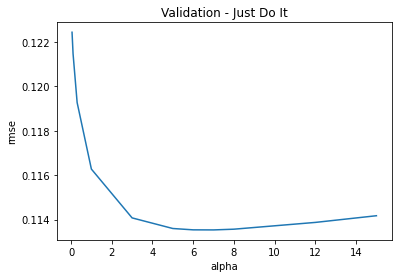

In [180]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [182]:
cv_ridge.min()

In [223]:
model_lasso = LassoCV(alphas = [3, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()

0.11051819941523622

In [224]:
# model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
# 0.11051819941523622
#
#
#
#
#
#

In [225]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [226]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 102 variables and eliminated the other 139 variables


In [227]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

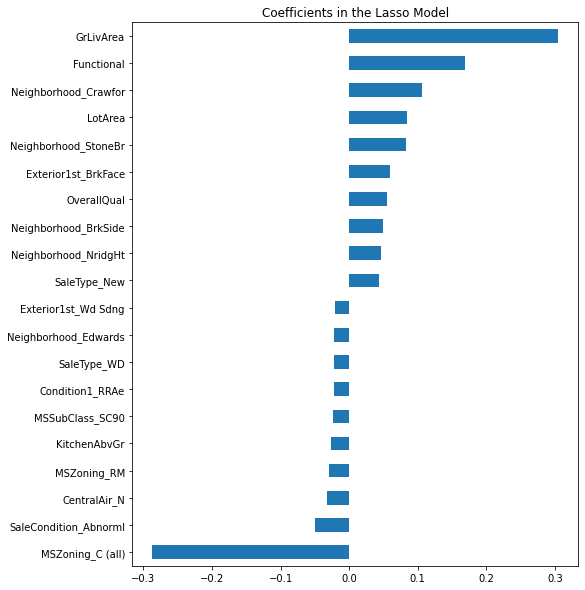

In [228]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [229]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

<AxesSubplot:>

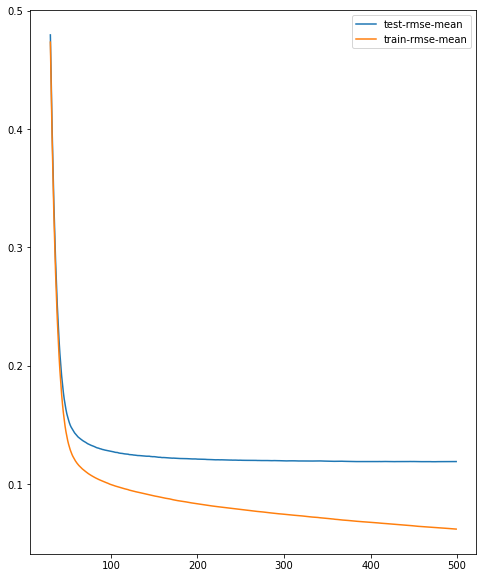

In [230]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [231]:
model_mk3 = XGBRegressor(colsample_bytree=0.4, learning_rate=0.02, max_depth=2, n_estimators=2500)
model_mk3.fit(X_train, y, verbose=False)
rmse_cv(model_mk3)

array([0.10580705, 0.12023968, 0.11913366, 0.10991085, 0.11640289])

In [232]:
# Resultados XGBR:
#model_mk3 = XGBRegressor(colsample_bytree=0.4, learning_rate=0.05, max_depth=2, n_estimators=1000)
#array([0.10729786, 0.12061268, 0.12051612, 0.11279443, 0.11387477])

#model_mk3 = XGBRegressor(colsample_bytree=0.4, learning_rate=0.03, max_depth=2, n_estimators=1000)
#array([0.10486259, 0.12102945, 0.12144519, 0.1113487 , 0.11554947])
#média = 0,1148

#model_mk3 = XGBRegressor(colsample_bytree=0.4, learning_rate=0.04, max_depth=2, n_estimators=1000)
#array([0.10762376, 0.11972693, 0.12043156, 0.11274567, 0.11651497])
#média = 0,1153

#model_mk3 = XGBRegressor(colsample_bytree=0.4, learning_rate=0.03, max_depth=4, n_estimators=1000)
#array([0.10836812, 0.12138675, 0.12100302, 0.110549  , 0.11504046])
#média = 0,1152

#model_mk3 = XGBRegressor(colsample_bytree=0.4, learning_rate=0.03, max_depth=3, n_estimators=1000)
#array([0.10705618, 0.12156923, 0.12029705, 0.11015782, 0.11553259])
#média = 0,1148

#model_mk3 = XGBRegressor(colsample_bytree=0.4, learning_rate=0.05, max_depth=3, n_estimators=1000)
#array([0.11043549, 0.1215128 , 0.12029638, 0.10974454, 0.11332869])
#média = 0,1150

#model_mk3 = XGBRegressor(colsample_bytree=0.4, learning_rate=0.05, max_depth=3, n_estimators=2000)
#array([0.1099581 , 0.12235381, 0.1206611 , 0.10999422, 0.11365745])
#média = 0,1152

#model_mk3 = XGBRegressor(colsample_bytree=0.4, learning_rate=0.03, max_depth=3, n_estimators=2500)
#array([0.10573891, 0.12224668, 0.11896385, 0.10906656, 0.11610178])
#média = 0,1144

#model_mk3 = XGBRegressor(colsample_bytree=0.4, learning_rate=0.02, max_depth=3, n_estimators=2500)
#array([0.1064937 , 0.12021861, 0.12007234, 0.10622904, 0.11571741])
#média = 0,1137

In [244]:
mk3_predictions = np.expm1(model_mk3.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

<AxesSubplot:xlabel='xgb', ylabel='lasso'>

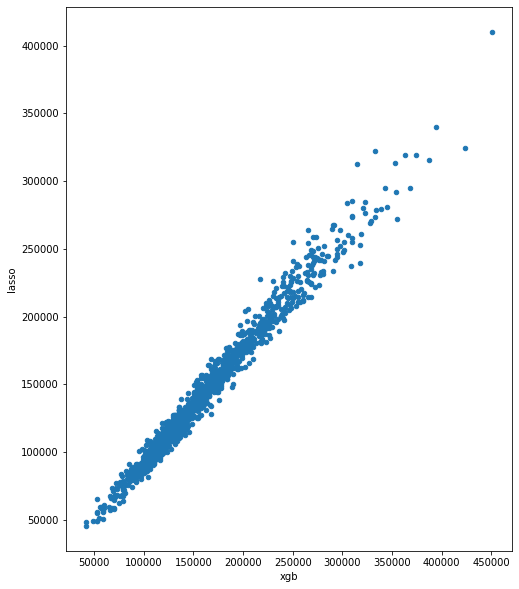

In [245]:
predictions = pd.DataFrame({"xgb":mk3_predictions, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [246]:
#preds = 0.3*lasso_preds + 0.7*mk3_predictions
# Submission LASSO x XGBR 1 e 2: preds = 0.7*lasso_preds + 0.3*mk3_predictions
# Submission LASSO x XGBR 3: preds = 0.5*lasso_preds + 0.5*mk3_predictions
# Submission LASSO x XGBR 4: preds = 0.3*lasso_preds + 0.7*mk3_predictions

<AxesSubplot:xlabel='xgb', ylabel='lasso'>

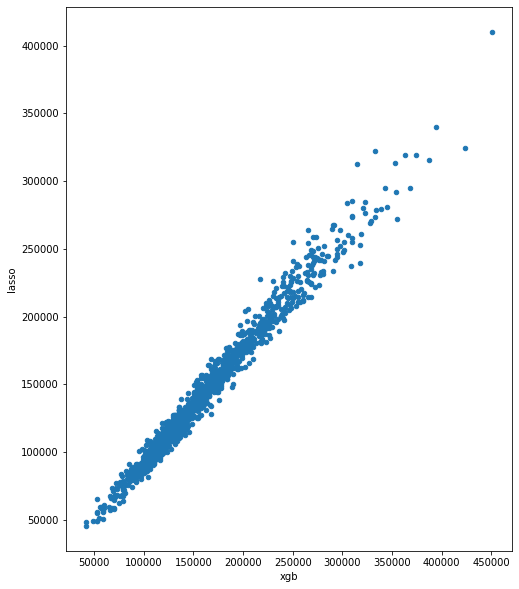

In [247]:
predictions = pd.DataFrame({"xgb":mk3_predictions, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

## Previsões e output.csv

In [250]:
solution = pd.DataFrame({"Id":test_ids, "SalePrice":mk3_predictions})
solution.to_csv("submission_LASSO_mk4.csv", index = False)